# Подготовка данных

Функция data_loader загружает батчи нужного размера для трейна и теста. Можно регулировать размер батча, трансформы, если они нам понадобятся, и долю тестовой выборки в датасете. Пример использования этой функции в разделе Test. Подключаемый файл data_preparation.py

Подключение файла:
- import data_preparation

Теперь по данным, нужно загрузить датасет LISA в ту же папку, что и ноутбуки все. Скачивается архив, распаковываешь его в папку с названием LISA, которая находится там же, где и ноутбуки.
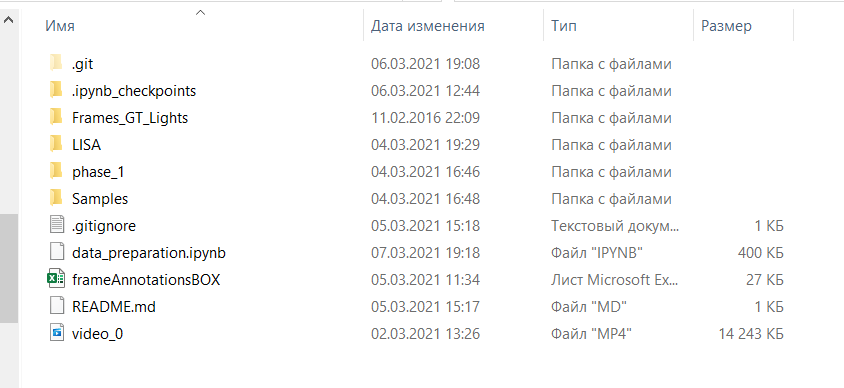

В папке LISA должны лежать вот эти файлы
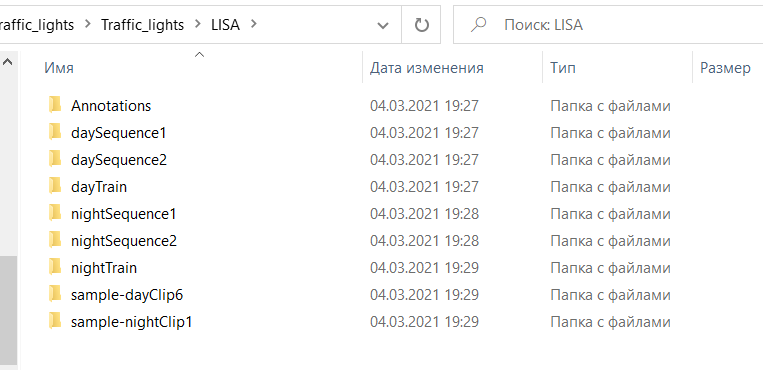

Больше ничего с файлами делать не требуется

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torchvision import transforms
import torchvision

In [2]:
cap = cv.VideoCapture("phase_1/video_0.MP4") # Вывод с видео файла
length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
print(length)
print(width)
print(height)

1203
1280
720


In [3]:
print(torch.__version__)

1.8.0+cu111


## Создание генератора датасета

### Создание класса датасета

In [4]:
class LISADataset(object):
    def __init__(self):
        # загрузка датасета аннотаций для bounding box'ов
        self.df = pd.read_csv("LISA\Annotations\Annotations\dayTrain\dayClip1\\frameAnnotationsBOX.csv", sep = ';')
        # упорядоченный список названий кадров из одной папки (пока что)
        imgs_temp = list(sorted(os.listdir(os.path.join("LISA\dayTrain\dayTrain\dayClip1", "frames"))))
        self.imgs = [imgs_temp[i] for i in self.df["Origin frame number"].unique()]

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join("LISA\dayTrain\dayTrain\dayClip1", "frames", self.imgs[idx])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)/255

        # get bounding box coordinates for each mask
        num_objs = len(self.df[self.df["Origin frame number"]==idx])
        boxes = []
        for i in range(num_objs):
            x_left = list(self.df[self.df["Origin frame number"]==idx]["Upper left corner X"])[i]
            x_right = list(self.df[self.df["Origin frame number"]==idx]["Lower right corner X"])[i]
            y_left = list(self.df[self.df["Origin frame number"]==idx]["Upper left corner Y"])[i]
            y_right = list(self.df[self.df["Origin frame number"]==idx]["Lower right corner Y"])[i]
            boxes.append([x_left, y_left, x_right, y_right])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if num_objs == 0:
            print(idx)
            boxes = torch.as_tensor([[0,0,0,0]], dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        
        img = torch.tensor(img, dtype=torch.float32)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
def data_loader(batch_size, transform = None, test_size = 0.2):
    
    dataset_train = LISADataset()
    dataset_test = LISADataset()
    indices = torch.randperm(len(dataset_train)).tolist()
    
    t = round(len(dataset_train)*test_size)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-t])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-t:])
    
    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    
    return data_loader_train, data_loader_test
    

# Test

Тут я тестирую созданные функции, можно не обращать внимание

In [58]:
torch.cuda.empty_cache()

In [7]:
device = torch.device('cuda:0')

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = LISADataset()
train, test = data_loader(batch_size = 2)
# For Training
images,targets = next(iter(train))
images = list(torch.reshape(image, (3, image.shape[0], image.shape[1])).to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.to(device)
model.train()
output = model(images,targets)   # Returns losses and detections

# For inference
images,targets = next(iter(test))
images = list(torch.reshape(image, (3, image.shape[0], image.shape[1])).to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.eval()
with torch.no_grad():
    predictions = model(images)           # Returns predictions

In [9]:
print(predictions)

[{'boxes': tensor([[   3.8678,   57.7042, 1273.9985,  876.9958],
        [ 185.7264,  229.1156,  489.7641,  607.2831],
        [ 133.6835,   93.4394,  808.7419,  832.9758]], device='cuda:0'), 'labels': tensor([7, 1, 7], device='cuda:0'), 'scores': tensor([0.6943, 0.1585, 0.0808], device='cuda:0')}, {'boxes': tensor([[  73.7560,   37.3438, 1260.7197,  910.1193],
        [ 232.7943,  255.6925,  959.9124,  909.2825],
        [ 826.7812,  542.2789, 1034.4065,  948.8951],
        [ 520.2996,  104.3694, 1265.7627,  780.5787],
        [ 473.6264,  350.0911, 1280.0000,  927.7017]], device='cuda:0'), 'labels': tensor([7, 7, 1, 7, 7], device='cuda:0'), 'scores': tensor([0.7715, 0.1773, 0.1507, 0.1125, 0.0537], device='cuda:0')}]


In [10]:
image = images[0].cpu().numpy()

In [11]:
def displayImage(image, boxes):
    boxes = boxes.cpu().numpy().astype(np.int32)
    image = np.reshape(image, (image.shape[1],image.shape[2], image.shape[0]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv.rectangle(image,
                      (box[2], box[3]),
                      (box[0], box[1]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


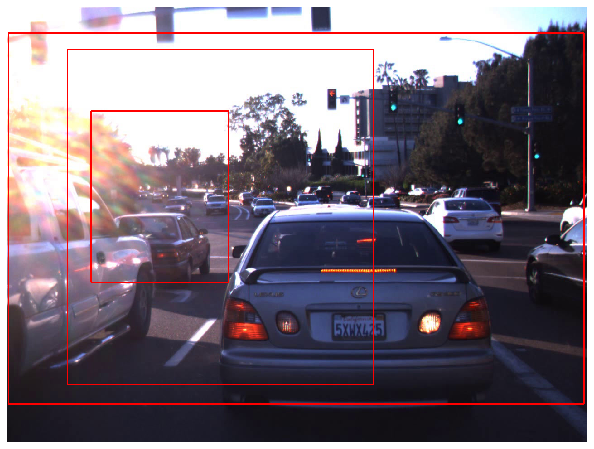

In [12]:
displayImage(image, predictions[0]['boxes'])

# Препроцессинг видео

In [ ]:
ret, frame = cap.read()

In [8]:
frame.shape

(720, 1280, 3)

In [5]:
cv.imshow("frame", frame)
cv.waitKey()
cv.destroyAllWindows()